# 2D Path Integration Task

## Set up

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


Set global seed

In [2]:
from lightning import seed_everything

seed = 42

seed_everything(seed)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

## Instantiate the task datamodule

The datamodule is responsible for loading the training and validation datasets.

This defines the inputs and outputs of the neural computation.

In [3]:
from datamodule import PathIntegrationDataModule

datamodule_config = {
    "trajectory_type": "ornstein_uhlenbeck",
    "velocity_representation": "polar",
    "dt": 0.1,  # s, (reasonable neural dynamics timescale)
    "num_time_steps": 20,
    "arena_size": 2.2,
    "linear_speed_mean": 0.2,
    "linear_speed_std": 0.5,
    "linear_speed_tau": 1.0,
    "angular_speed_mean": 0.0,
    "angular_speed_std": 1.2,
    "angular_speed_tau": 0.4,
    "num_place_cells": 512,
    "place_cell_rf": 0.2,
    "DoG": True,
    "surround_scale": 2,
    "place_cell_layout": "random",
    "num_trajectories": 1000,
    "batch_size": 200,
    "num_workers": 7,
    "train_val_split": 0.8,
}

datamodule = PathIntegrationDataModule(**datamodule_config)
datamodule.setup()

### Visualize example trajectory

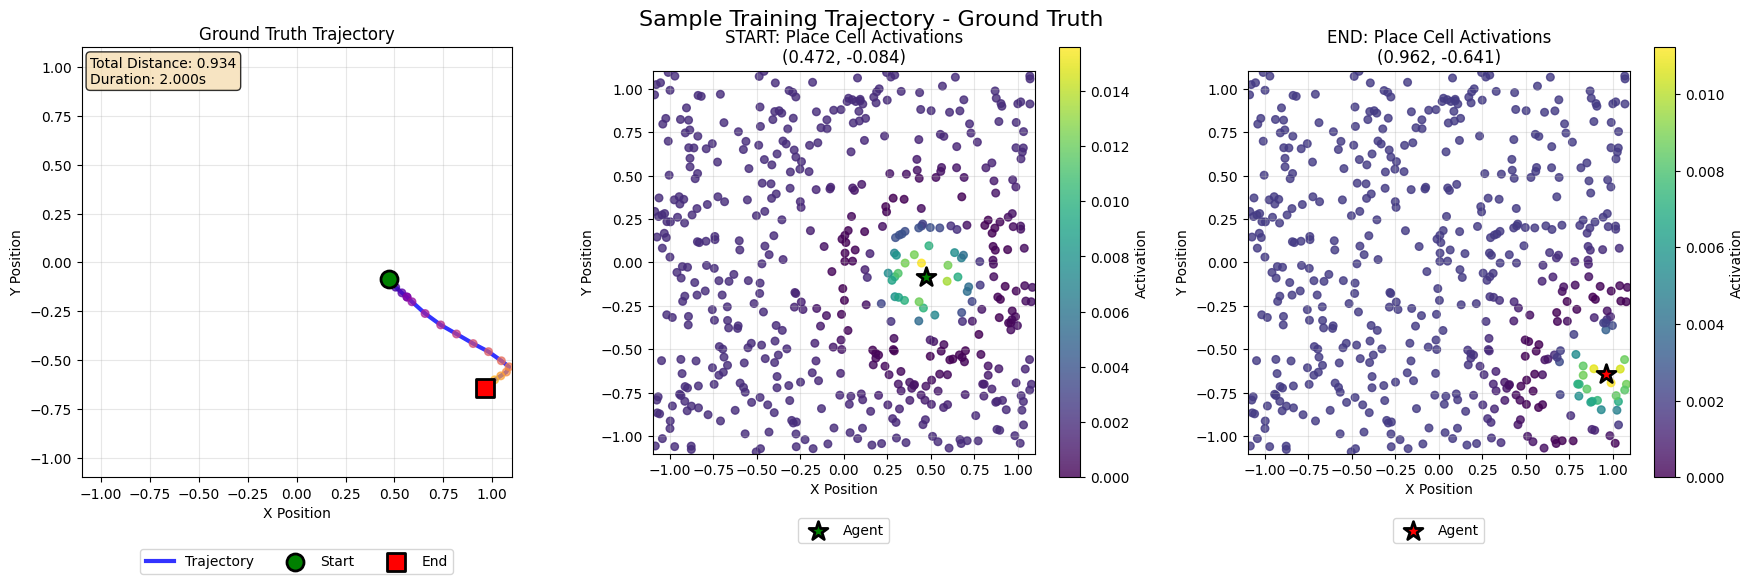

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch from the dataloader
loader = datamodule.train_dataloader()
batch_inputs, batch_positions, batch_place_cells = next(iter(loader))

# Select first trajectory from batch
traj_idx = 0
positions = batch_positions[traj_idx, :, :].numpy()
place_cells = batch_place_cells[traj_idx, :, :].numpy()
inputs = batch_inputs[traj_idx, :, :].numpy()

# Set consistent axis limits based on arena size (centered at origin)
lim = datamodule.arena_size / 2
xlim = [-lim, lim]
ylim = [-lim, lim]

# Create figure with 3 subplots: trajectory + 2 place cell plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# === TRAJECTORY PLOT ===
ax_traj = axes[0]

# Plot trajectory path
ax_traj.plot(
    positions[:, 0],
    positions[:, 1],
    "b-",
    linewidth=3,
    label="Trajectory",
    alpha=0.8,
)

# Mark start and end points
ax_traj.scatter(
    positions[0, 0],
    positions[0, 1],
    c="green",
    s=150,
    marker="o",
    label="Start",
    zorder=5,
    edgecolors="black",
    linewidth=2,
)
ax_traj.scatter(
    positions[-1, 0],
    positions[-1, 1],
    c="red",
    s=150,
    marker="s",
    label="End",
    zorder=5,
    edgecolors="black",
    linewidth=2,
)

# Mark all points to see trajectory progression
ax_traj.scatter(
    positions[:, 0],
    positions[:, 1],
    c=range(len(positions)),
    cmap="plasma",
    s=30,
    alpha=0.7,
    zorder=3,
)

ax_traj.set_xlabel("X Position")
ax_traj.set_ylabel("Y Position")
ax_traj.set_title("Ground Truth Trajectory")
ax_traj.legend(bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=3)
ax_traj.grid(True, alpha=0.3)
ax_traj.set_aspect("equal")
ax_traj.set_xlim(xlim)
ax_traj.set_ylim(ylim)

# Add trajectory info
total_distance = np.sum(np.sqrt(np.sum(np.diff(positions, axis=0) ** 2, axis=1)))
ax_traj.text(
    0.02,
    0.98,
    f"Total Distance: {total_distance:.3f}\nDuration: {len(positions) * datamodule.dt:.3f}s",
    transform=ax_traj.transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
)

# === PLACE CELL ACTIVATION PLOTS ===
place_centers = datamodule.place_cell_centers.numpy()

# START TIME - Place Cells
ax_start = axes[1]
start_activations = place_cells[0, :]  # t=0
start_pos = positions[0]

scatter_start = ax_start.scatter(
    place_centers[:, 0],
    place_centers[:, 1],
    c=start_activations,
    cmap="viridis",
    s=30,
    alpha=0.8,
)
# Mark agent position
ax_start.scatter(
    start_pos[0],
    start_pos[1],
    c="green",
    s=200,
    marker="*",
    label="Agent",
    zorder=5,
    edgecolors="black",
    linewidth=2,
)

ax_start.set_xlabel("X Position")
ax_start.set_ylabel("Y Position")
ax_start.set_title(
    f"START: Place Cell Activations\n({start_pos[0]:.3f}, {start_pos[1]:.3f})"
)
ax_start.legend(bbox_to_anchor=(0.5, -0.15), loc="upper center")
ax_start.grid(True, alpha=0.3)
ax_start.set_aspect("equal")
ax_start.set_xlim(xlim)
ax_start.set_ylim(ylim)
cbar_start = plt.colorbar(scatter_start, ax=ax_start)
cbar_start.set_label("Activation")

# END TIME - Place Cells
ax_end = axes[2]
end_activations = place_cells[-1, :]  # t=final
end_pos = positions[-1]

scatter_end = ax_end.scatter(
    place_centers[:, 0],
    place_centers[:, 1],
    c=end_activations,
    cmap="viridis",
    s=30,
    alpha=0.8,
)
# Mark agent position
ax_end.scatter(
    end_pos[0],
    end_pos[1],
    c="red",
    s=200,
    marker="*",
    label="Agent",
    zorder=5,
    edgecolors="black",
    linewidth=2,
)

ax_end.set_xlabel("X Position")
ax_end.set_ylabel("Y Position")
ax_end.set_title(f"END: Place Cell Activations\n({end_pos[0]:.3f}, {end_pos[1]:.3f})")
ax_end.legend(bbox_to_anchor=(0.5, -0.15), loc="upper center")
ax_end.grid(True, alpha=0.3)
ax_end.set_aspect("equal")
ax_end.set_xlim(xlim)
ax_end.set_ylim(ylim)
cbar_end = plt.colorbar(scatter_end, ax=ax_end)
cbar_end.set_label("Activation")

fig.suptitle("Sample Training Trajectory - Ground Truth", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

## Instantiate the model to be trained on the task

In [5]:
from pirnns.rnns.rnn import RNN
import torch.nn as nn


model_config = {
    "input_size": 2,
    "hidden_size": 4096,
    "num_place_cells": 512,
    "alpha": 1,
    "activation": "ReLU",
}

model = RNN(
    input_size=model_config["input_size"],
    hidden_size=model_config["hidden_size"],
    output_size=model_config["num_place_cells"],
    alpha=model_config["alpha"],
    activation=getattr(nn, model_config["activation"]),
)

print(model)

# print the number of parameters
print("Number of trainable parameters: ", sum(p.numel() for p in model.parameters()))

RNN(
  (rnn_step): RNNStep(
    (activation): ReLU()
    (W_in): Linear(in_features=2, out_features=4096, bias=True)
    (W_rec): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (W_out): Linear(in_features=4096, out_features=512, bias=False)
  (W_h_init): Linear(in_features=512, out_features=4096, bias=False)
)
Number of trainable parameters:  20987904


## Instantiate the lightning module and Trainer

The model lightning module is responsible for implementing the training and validation steps.

This involves defining the loss function, the optimizer, and the learning rate scheduler.

The trainer is responsible for training the model.

In [6]:
from pirnns.rnns.rnn import RNNLightning
import torch

lightning_config = {
    "learning_rate": 0.01,
    "weight_decay": 1.0e-4,
    "step_size": 100,
    "gamma": 0.5,
}

rnn_lightning = RNNLightning(model=model, **lightning_config)

device = "cuda" if torch.cuda.is_available() else "cpu"

rnn_lightning.to(device)

print(rnn_lightning)
print(f"Training on device: {device}")

RNNLightning(
  (model): RNN(
    (rnn_step): RNNStep(
      (activation): ReLU()
      (W_in): Linear(in_features=2, out_features=4096, bias=True)
      (W_rec): Linear(in_features=4096, out_features=4096, bias=True)
    )
    (W_out): Linear(in_features=4096, out_features=512, bias=False)
    (W_h_init): Linear(in_features=512, out_features=4096, bias=False)
  )
)
Training on device: cuda


## Train the model

In [7]:
import lightning as L
from callbacks import LossLoggerCallback

loss_logger = LossLoggerCallback(save_dir="logs")

trainer = L.Trainer(
    max_epochs=5,  # small for illustration purposes
    logger=False,
    callbacks=[loss_logger],
    num_sanity_val_steps=0,
)

train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()

trainer.fit(rnn_lightning, train_dataloader, val_dataloader)

INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheck

Epoch 4: 100%|██████████| 400/400 [00:51<00:00,  7.76it/s, train_loss_step=6.120, val_loss=6.130, train_loss_epoch=6.140]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 400/400 [00:52<00:00,  7.58it/s, train_loss_step=6.120, val_loss=6.130, train_loss_epoch=6.140]


## Visualize training and validation loss

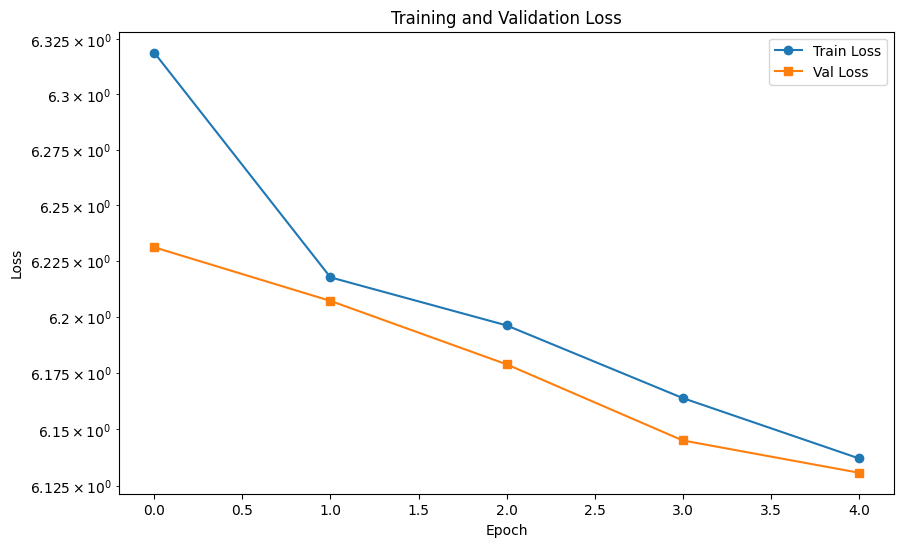

Final train loss: 6.137218
Final val loss: 6.130888
Best val loss: 6.130888 at epoch 4


In [10]:
train_losses = loss_logger.train_losses_epoch
val_losses = loss_logger.val_losses_epoch

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
# plt.grid(True)
plt.yscale("log")  # Often useful for loss curves
plt.show()

print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Final val loss: {val_losses[-1]:.6f}")
print(
    f"Best val loss: {min(val_losses):.6f} at epoch {val_losses.index(min(val_losses))}"
)